In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials, select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy import stats
seed=2024

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def get_unit(path, time_before):
    neu_data = NeuronData.from_python_hdf5(path)
    dict_att = {"in": {}, "out": {}}
    for att, i_att in zip(["in", "out"], [1, -1]):
        # get spike matrices in and out conditions
        sp_in, mask_in = align_trials.get_align_tr(
            neu_data,
            select_block=1,
            select_pos=i_att,
            time_before=time_before,
            event="sample_on",
        )
        if np.mean(sp_in[:, 200:1000]) < 5 / 1000:

            return None
        else:
            sp_samples = select_trials.get_sp_by_sample(
                sp_in[:, : time_before + 1000],
                neu_data.sample_id[mask_in],
                samples=[0, 11, 15, 55, 51],
            )
        for key in sp_samples.keys():  # At least 5 trials per condition
            if sp_samples[key].shape[0] < 2:
                return None
        sp_samples["path"] = path
        sp_samples["n_type"] = neu_data.cluster_group
        dict_att[att] = sp_samples
    return dict_att

In [5]:
def get_cv_scores(model, X, y, seed=None, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=seed)  # Create KFold object
    train_scores, test_scores = [], []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ss = StandardScaler(with_mean=True, with_std=True)
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        # ss = StandardScaler(with_mean=True, with_std=True)
        # y_train = ss.fit_transform(y_train)
        # y_test = ss.transform(y_test)
        model.fit(X_train, y_train)  # Train the model on the training fold
        train_scores.append((model.score(X_train, y_train)))  # Record training score
        test_scores.append((model.score(X_test, y_test)))  # Record testing score
    return train_scores, test_scores

In [6]:
def get_lambda_cv_scores(model, X, y, lambdas, seed,cv=5):
    """Compute the mean training and testing scores for each regularization parameter (lambda).
    Args:
        model (sklearn):  model to use.
        X (numpy.ndarray): The input features.
        y (numpy.ndarray): The target values.
        lambdas (list): A list of regularization parameters (lambda values) to try.
        cv (int): The number of folds for cross-validation.
    """
    train_scores, test_scores = [], []
    for lam in lambdas:
        model.set_params(alpha=lam)  # Set regularization parameter
        i_train_scores,i_test_scores = get_cv_scores(model, X, y, cv=cv,seed=seed)
        train_scores.append(i_train_scores)
        test_scores.append(i_test_scores )
    return train_scores,test_scores

In [7]:
def moving_average(data: np.ndarray, win: int, step: int = 1) -> np.ndarray:
    d_shape = data.shape
    count = 0
    if len(d_shape) == 3:
        steps = np.arange(0, d_shape[2] - win, step)
        d_avg = np.zeros((d_shape[0], d_shape[1], steps.shape[0]))
        for i_step in steps:
            d_avg[:, :, count] = np.mean(data[:, :, i_step : i_step + win], axis=2)
            count += 1

    return d_avg

In [8]:
np.ones((10,2,3))[[0,2,5,6],:,:].shape

(4, 2, 3)

In [9]:
def select_neurons(i_n,x_in,y_in,x_out=None,y_out=None,time_before=None,win=None,step=None,t_st=None,t_end=None):
    # IN
    idx_neurons = np.random.choice(x_in.shape[0],i_n,replace=False)
    if i_n == 1:
        idx_neurons=[idx_neurons]
    x_in=moving_average(data=x_in, win=win, step=step)[idx_neurons]#[idx_neurons,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
    y_in=moving_average(data=y_in, win=win, step=step)#[:,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
    x_in=(x_in.reshape(x_in.shape[0],-1).T)
    y_in=(y_in.reshape(y_in.shape[0],-1).T)
    # ss = StandardScaler(with_mean=True, with_std=True)
    # x_in=ss.fit_transform(x_in)
    # ss = StandardScaler(with_mean=True, with_std=True)
    # y_in=ss.fit_transform(y_in)
    if x_out is not None:
        # OUT
        x_out=moving_average(data=x_out, win=win, step=step)[idx_neurons]#[idx_neurons,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
        y_out=moving_average(data=y_out, win=win, step=step)#[:,:,int((time_before+t_st)/step):int((time_before+t_end)/step)]
        x_out=(x_out.reshape(x_out.shape[0],-1).T)
        y_out=(y_out.reshape(y_out.shape[0],-1).T)
        # ss = StandardScaler(with_mean=True, with_std=True)
        # x_out=ss.fit_transform(x_out)
        # ss = StandardScaler(with_mean=True, with_std=True)
        # y_out=ss.fit_transform(y_out)
    return x_in,y_in,x_out,y_out

In [10]:
def run_iteration(units_info, area_x, area_y, sample, lams, seed, params):
    best_acc = [[], []]
    np.random.seed(seed=seed)
    step = params["step"]
    t_st = params["t_st"]
    t_end = params["t_end"]
    win = params["win"]
    time_before = params["time_before"]
    x_in_all = units_info[area_x]["in"][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
    y_in_all = units_info[area_y]["in"][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
    x_out_all = units_info[area_x]["out"][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
    y_out_all = units_info[area_y]["out"][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
    for i_n in range(1, units_info[area_x]["in"][sample].shape[0] + 1):

        x_in, y_in, x_out, y_out = select_neurons(
            i_n,
            x_in=x_in_all,
            y_in=y_in_all,
            x_out=x_out_all,
            y_out=y_out_all,
            time_before=time_before,
            win=win,
            step=step,
            t_st=t_st,
            t_end=t_end,
        )
        # f,ax=plt.subplots(1,2,figsize=(10,6),sharey=True)
        for i, (i_x, i_y) in enumerate(zip([x_in, x_out], [y_in, y_out])):
            ridge_model = Ridge(fit_intercept=True)
            train_scores, test_scores = get_lambda_cv_scores(
                ridge_model, i_x, i_y, lams, seed=seed, cv=10
            )
            std_score = np.std(test_scores, axis=1)
            mean_score = np.mean(test_scores, axis=1)
            im = np.argmax(mean_score)
            best_acc[i].append(mean_score[im])
    return best_acc

## Read data

In [11]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/"
    )
elif platform.system() == "Windows":
    basepath = 'D:/data/'#"C:/Users/camil/Documents/int/"

In [37]:
area_x = "pfc"
area_y = "v4"
session = '2022-12-05_10-51-52'
comment = (
    "Accuracy of predicting %s activity from %s activity using linear regression"
    % (area_y, area_x)
)
areas = [area_x, area_y]
subject = "Riesling"
time_before = 200
step = 20
t_st = 0
t_end = 220
win = 100
lams = np.logspace(0, 50, num=50, base=1.4, endpoint=False) * 1e-4
n_iterations = 5
params = {
    "step": step,
    "t_st": t_st,
    "t_end": t_end,
    "win": win,
    "time_before": time_before,
}
date=datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [38]:
units_path = {'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath + "session_struct/" + area + "/neurons/*neu.h5"
    path_list = np.array(glob.glob(neu_path))
    mask=[]
    for path in path_list:
        mask.append(session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0])
    path_list=path_list[mask]
    units_path[area]['paths']=path_list
    

In [39]:
area_info={}
for area in areas:
    path_list = units_path[area]['paths']

    info = Parallel(n_jobs=-1)(
        delayed(get_unit)(path_list[i],time_before)for i in tqdm(range(len(path_list)))
    )
    area_info[area] = info

100%|██████████| 73/73 [00:21<00:00,  3.47it/s]


In [40]:
units_info = {'v4':{'in':{},'out':{}},'pfc':{'in':{},'out':{}}}
for area in areas:
    for att in ['in','out']:
        paths,n_type,attention=[],[],[]
        sp11=[]
        sp15=[]
        sp51=[]
        sp55=[]
        sp0=[]
        for i_info in area_info[area]:
            if i_info is not None:
                paths.append(i_info[att]['path'])
                sp11.append(i_info[att]['11'])
                sp15.append(i_info[att]['15'])
                sp51.append(i_info[att]['51'])
                sp55.append(i_info[att]['55'])
                sp0.append(i_info[att]['0'])
                n_type.append(i_info[att]['n_type'])
        units_info[area][att]['paths'] = np.array(paths)
        units_info[area][att]['11'] = np.array(sp11)
        units_info[area][att]['15'] = np.array(sp15)
        units_info[area][att]['51'] = np.array(sp51)
        units_info[area][att]['55'] = np.array(sp55)
        units_info[area][att]['0'] = np.array(sp0)
        units_info[area][att]['n_type'] = np.array(n_type)

## Preproces and test on one model

In [41]:
sample='15'
x_in=units_info['pfc']['in'][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
y_in=units_info['v4']['in'][sample][:,:,int(time_before+t_st):int(time_before+t_end)]
i_n=x_in.shape[0]
x,y,_,_=select_neurons(i_n,x_in,y_in,x_out=None,y_out=None,time_before=time_before,win=win,step=step,t_st=t_st,t_end=t_end)
print(x.shape)
print(y.shape)

(294, 27)
(294, 31)


In [42]:
x_in.shape[0]

27

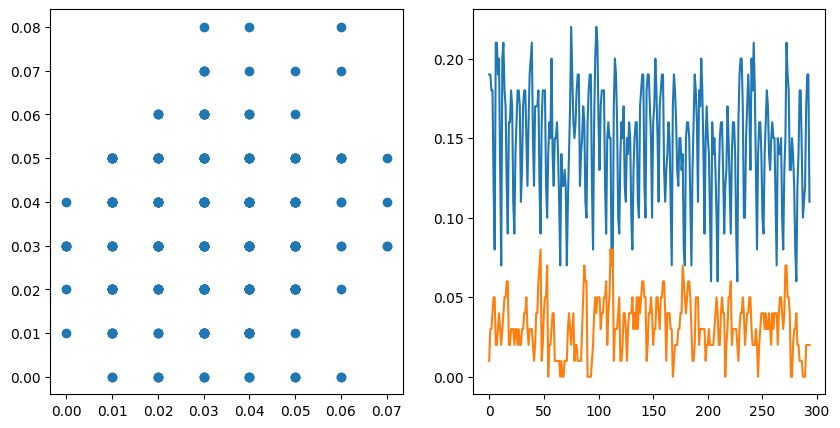

In [43]:
f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x[:,10],x[:,1])
for i in range(2):
    ax[1].plot(x[:500,i])

#### Test result in one condition

0.00965178157813665

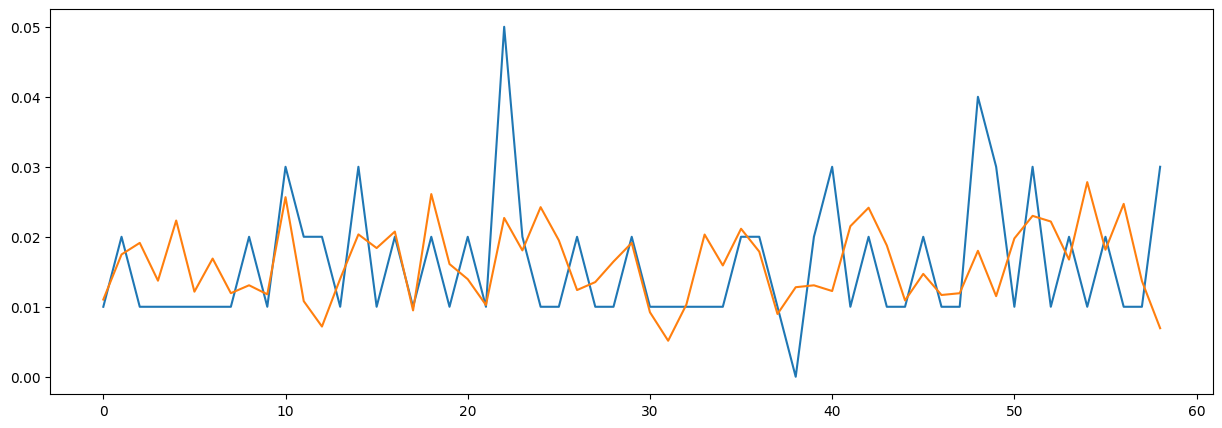

In [44]:
i_n=0
# ss = StandardScaler(with_mean=True, with_std=False)
# y = ss.fit_transform(y)

X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2)
ss = StandardScaler(with_mean=True, with_std=True)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

lr_m = LinearRegression( fit_intercept=True,n_jobs=-1)
lr_m.fit(X_train,y_train)
y_pred = lr_m.predict(X_test)
plt.subplots(figsize=(15,5))
plt.plot(y_test[:1600,i_n])
plt.plot(y_pred[:1600,i_n])
#print(1-metrics.mean_squared_error(y_pred,y))
lr_m.score(x,y)

In [45]:
rng = np.random.RandomState(seed)
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
kf = KFold(n_splits=10, shuffle=True, random_state=seed)
linear_scores = cross_val_score(linear_model, x, y, cv=kf,scoring='r2')
print(linear_scores)
print(np.mean(linear_scores))

[ 0.13764912  0.11461285  0.0459959   0.0642196   0.09699397  0.08918642
  0.10816485 -0.01025588  0.09624459  0.02055065]
0.07633620548660688


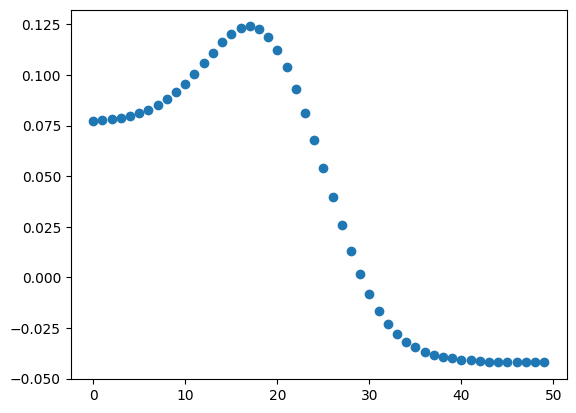

In [46]:
all_scores=[]
for lam in lams:
    rng = np.random.RandomState(seed)
    ridge_model = Ridge(alpha=lam,fit_intercept=True)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    ridge_scores = cross_val_score(ridge_model, x, y, cv=kf,n_jobs=-1,scoring='r2')
    all_scores.append(ridge_scores)
plt.scatter(range(len(lams)),np.mean(all_scores,axis=1))

#### With my functions

In [47]:
linear_model = LinearRegression( fit_intercept=True,n_jobs=-1)
train_scores,test_scores=get_cv_scores(linear_model, x, y, seed=seed,cv=10)
print((train_scores))
print((test_scores))
mean_train_score = np.mean(train_scores)
print(mean_train_score)
mean_test_score = np.mean(test_scores)
print(mean_test_score)

[0.3044094477592962, 0.3039594783283928, 0.3095834916978093, 0.3076999088279531, 0.3078606535608896, 0.3074526695371616, 0.3063179581173214, 0.3099045768371321, 0.3063095784882261, 0.3115217225794082]
[0.13764911983671688, 0.11461284647800357, 0.045995896478286995, 0.06421959677224477, 0.09699396988758384, 0.089186419776125, 0.10816484749505643, -0.010255877031987489, 0.09624458563154337, 0.020550649542493953]
0.307501948573359
0.07633620548660673


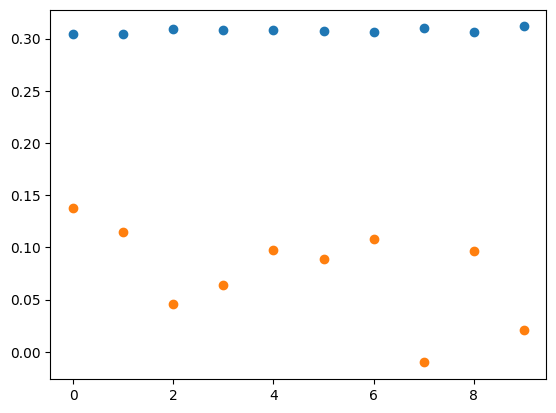

In [48]:
plt.scatter(range(10),train_scores)
plt.scatter(range(10),test_scores)

137.20738853184935
0.12611693093356396


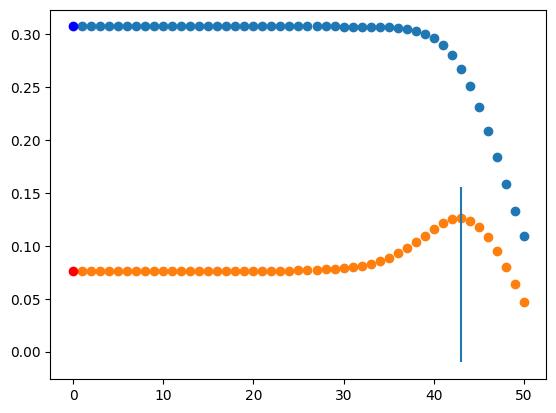

In [49]:
ridge_model = Ridge(fit_intercept=True)
train_scores,test_scores=get_lambda_cv_scores(ridge_model, x, y, lams, seed=seed,cv=10)
# plots
plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1))
plt.scatter([0],[mean_train_score],color='b')
#plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1)-np.std(train_scores,axis=1),'b--')
plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1))
#plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1)+np.std(test_scores,axis=1),'g--')
plt.scatter([0],[mean_test_score],color='r')
im=np.argmax(np.mean(test_scores,axis=1))
plt.vlines(im+1,np.min(test_scores),np.max(test_scores))
print(lams[im])
print(np.mean(test_scores,axis=1)[im])

137.20738853184935
0.12611693093356396


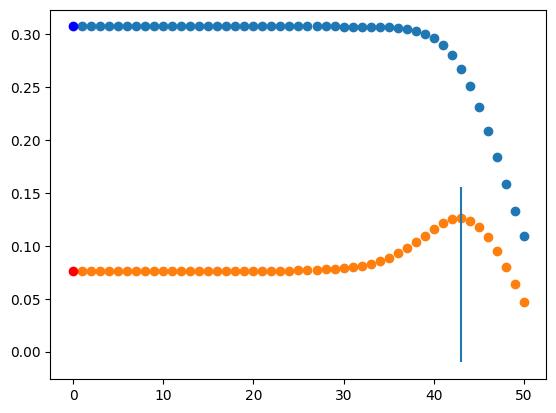

In [50]:
ridge_model = Ridge(fit_intercept=True)
train_scores,test_scores=get_lambda_cv_scores(ridge_model, x, y, lams, seed=seed,cv=10)
# plots
plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1))
plt.scatter([0],[mean_train_score],color='b')
#plt.scatter(range(1,len(lams)+1),np.mean(train_scores,axis=1)-np.std(train_scores,axis=1),'b--')
plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1))
#plt.scatter(range(1,len(lams)+1),np.mean(test_scores,axis=1)+np.std(test_scores,axis=1),'g--')
plt.scatter([0],[mean_test_score],color='r')
im=np.argmax(np.mean(test_scores,axis=1))
plt.vlines(im+1,np.min(test_scores),np.max(test_scores))
print(lams[im])
print(np.mean(test_scores,axis=1)[im])

## Train and Test one model for each condition (* n_iterations)

In [51]:
plt.close()

In [52]:
acc={}
for sample in ['51','11','55','15','0']:
    it_best_acc=[]
    np.random.seed(seed=seed)
    n_seeds = np.random.choice(6000,n_iterations,replace=False)
    data = Parallel(n_jobs=-1)(
        delayed(run_iteration)(
            units_info=units_info,area_x=area_x,area_y=area_y,sample=sample, lams=lams, seed=i_seed, params=params
        )
        for i_seed in tqdm(n_seeds)
    )
    it_best_acc=[]
    for i_data in data:
        it_best_acc.append(i_data)
    acc[sample]=it_best_acc
    

100%|██████████| 5/5 [00:00<00:00, 1668.11it/s]


In [53]:
acc['comment']=comment
acc['session']=session
acc['computation_date']=date
for key,value in params.items():
    acc[key]=value
for i_samp in ['51','11','55','15','0']:
    for i_cond in ['in','out']:
        x_in = units_info[area_x][i_cond][i_samp][:,:,int(time_before+t_st):int(time_before+t_end)]
        y_in = units_info[area_y][i_cond][i_samp][:,:,int(time_before+t_st):int(time_before+t_end)]
        key = area_x+ '_'+i_samp + '_' + i_cond
        acc[key] = x_in
        key = area_y+ '_'+i_samp + '_' + i_cond
        acc[key] = y_in

In [54]:
to_python_hdf5(dat=[acc], save_path='./test.h5')

In [55]:
dat=from_python_hdf5('./test.h5')[0]

In [56]:
dat.keys()
mean_frx ={'51':{},'11':{},'55':{},'15':{},'0':{}}
mean_fry ={'51':{},'11':{},'55':{},'15':{},'0':{}}
for i_samp in ['51','11','55','15','0']:
    for i_cond in ['in','out']:
        xkey = area_x+ '_'+i_samp + '_' + i_cond
        meanx=np.mean(acc[xkey],axis=-1)*1000
        ykey = area_y+ '_'+i_samp + '_' + i_cond
        meany=np.mean(acc[ykey],axis=-1)*1000
        mean_frx[i_samp][i_cond]=meanx
        mean_fry[i_samp][i_cond]=meany

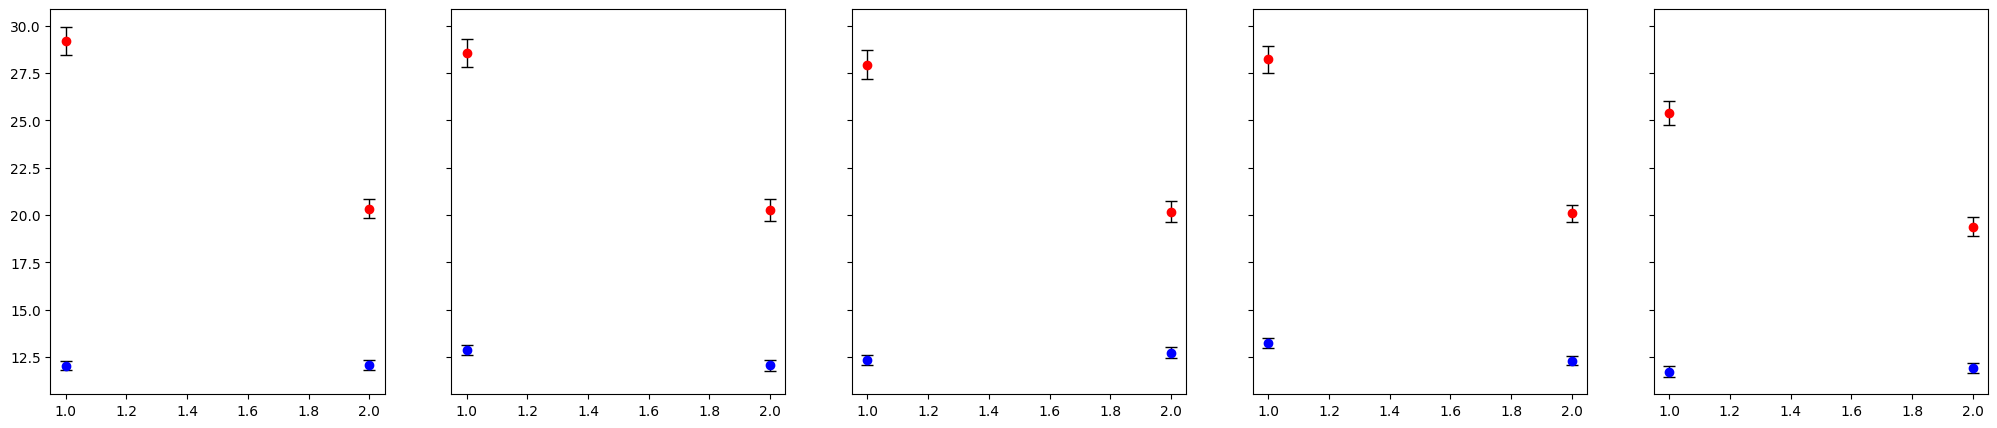

In [57]:
f,ax=plt.subplots(1,5,figsize=(25,5),sharey=True,sharex=True)
allxerr,allyerr=[],[]
for iax,i_samp in enumerate(['11','15','51','55','0']):
    # area x
    meanfr = np.mean(mean_frx[i_samp]['in'])
    stdfr= stats.sem(mean_frx[i_samp]['in'],axis=None)
    _=ax[iax].scatter(1,meanfr,label=['in'] ,color='r')
    ax[iax].errorbar(x=1,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    meanfr = np.mean(mean_frx[i_samp]['out'])
    stdfr= stats.sem(mean_frx[i_samp]['out'],axis=None)
    _=ax[iax].scatter(2,meanfr,label=['out'],color='r' )
    ax[iax].errorbar(x=2,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    # area y
    meanfr = np.mean(mean_fry[i_samp]['in'])
    stdfr= stats.sem(mean_fry[i_samp]['in'],axis=None)
    _=ax[iax].scatter(1,meanfr,label=['in'] ,color='b')
    ax[iax].errorbar(x=1,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)
    meanfr = np.mean(mean_fry[i_samp]['out'])
    stdfr= stats.sem(mean_fry[i_samp]['out'],axis=None)
    _=ax[iax].scatter(2,meanfr,label=['out'],color='b' )
    ax[iax].errorbar(x=2,y=meanfr,yerr=stdfr,fmt='none', ecolor='black', elinewidth=1,capsize=4,zorder=-1)

In [58]:
# basepath = 'C:/Users/camil/Documents/int/result/'
# neu_path = basepath + "*.h5"
# path_list = np.array(glob.glob(neu_path))
# all_sess = []
# for path in path_list:
#     all_sess.append(from_python_hdf5(load_path=path)[0])

In [59]:
from scipy import stats

Text(0.5, 0.98, 'ccuracy of predicting v4 activity from pfc activity using linear regression - Number of predicted neurons:31')

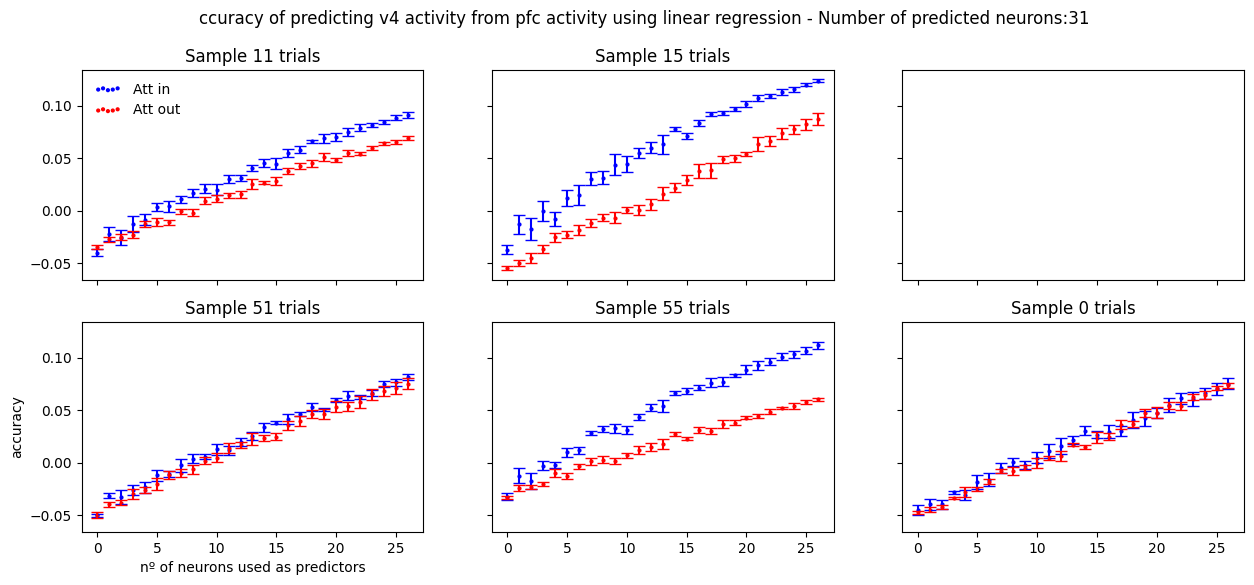

In [60]:
n_neux = units_info[area_x]["in"]["11"].shape[0]
n_neuy = units_info[area_y]["in"]["11"].shape[0]

comment=acc['comment']
ncols=3
nrows=2
f,ax=plt.subplots(nrows,ncols,figsize=(15,6),sharey=True,sharex=True)
col=[0,1,0,1,2]
row=[0,0,1,1,1]
for isample,irow,icol in zip(['11','15','51','55','0'],row,col):

    ax[irow,icol].scatter(range(n_neux),np.mean(np.array(acc[isample])[:,0],axis=0),color='b',label='Att in',s=4)
    ax[irow,icol].errorbar(range(n_neux),np.mean(np.array(acc[isample])[:,0],axis=0),yerr=stats.sem(np.array(acc[isample])[:,0],axis=0),ecolor='b',fmt='none',capsize=4)
    ax[irow,icol].scatter(range(n_neux),np.mean(np.array(acc[isample])[:,1],axis=0),color='r',label='Att out',s=4)
    ax[irow,icol].errorbar(range(n_neux),np.mean(np.array(acc[isample])[:,1],axis=0),yerr=stats.sem(np.array(acc[isample])[:,1],axis=0),ecolor='r',fmt='none',capsize=4)
    ax[irow,icol].set(title='Sample %s trials'%isample)

ax[0,0].legend(fontsize=10, scatterpoints=5, columnspacing=0.5, framealpha=0, loc="best")
ax[1, 0].set(ylabel="accuracy", xlabel="nº of neurons used as predictors")
f.suptitle(str(comment)[1:] + " - Number of predicted neurons:" + str(n_neuy))